In [47]:
import yfinance as yf
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import CLA
import pypfopt
import matplotlib.pyplot as plt
import datetime
from datetime import date
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.stats import norm
from sklearn import preprocessing
import functools

#rio = yf.Ticker("RIO")
#bhp=yf.Ticker('BHP')
#hist = rio.history(period="5y")
#print(len(hist))



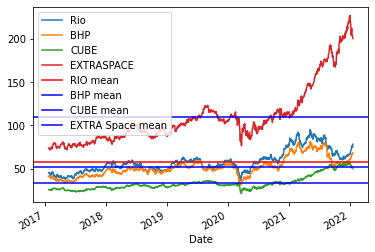

Correlation Open               0.977209
High               0.977112
Low                0.977059
Close              0.977170
Adj Close          0.973981
Volume             0.531366
open_pct_change    0.872907
dtype: float64


In [8]:
rio_df=pd.read_csv('RIO.csv',parse_dates=['Date'],index_col=0)
bhp_df=pd.read_csv('BHP.csv',parse_dates=['Date'],index_col=0)
cube_df=pd.read_csv('CUBE.csv',parse_dates=['Date'],index_col=0)
extra_df=pd.read_csv('EXR.csv',parse_dates=['Date'],index_col=0)
filter=((rio_df.index>'1/1/2017') & (rio_df.index<='1/20/2022'))
rio_df=rio_df[filter]
rio_df['Open'].plot(label='Rio')
filter=((bhp_df.index>'1/1/2017') & (bhp_df.index<='1/20/2022'))
bhp_df=bhp_df[filter]
bhp_df['Open'].plot(label='BHP')
filter=((cube_df.index>'1/1/2017') & (cube_df.index<='1/20/2022'))
cube_df=cube_df[filter]
cube_df['Open'].plot(label='CUBE')

filter=((extra_df.index>'1/1/2017') & (extra_df.index<='1/20/2022'))
extra_df=extra_df[filter]
extra_df['Open'].plot(label='EXTRASPACE')

rio_df['open_pct_change']=rio_df['Open'].pct_change()
bhp_df['open_pct_change']=bhp_df['Open'].pct_change()
cube_df['open_pct_change']=cube_df['Open'].pct_change()
extra_df['open_pct_change']=extra_df['Open'].pct_change()

mean = rio_df['Open'].mean()
plt.axhline(y=mean, color='r', linestyle='-',label='RIO mean')

mean = bhp_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='BHP mean')

mean = cube_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='CUBE mean')

mean = extra_df['Open'].mean()
plt.axhline(y=mean, color='b', linestyle='-',label='EXTRA Space mean')

plt.legend()
plt.show()
print("Correlation",rio_df.corrwith(bhp_df,axis=0))

In [9]:
portfolio_returns_rio=rio_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_bhp=bhp_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_cube=cube_df.resample('Q')['Open'].sum().reset_index()
portfolio_returns_extra=extra_df.resample('Q')['Open'].sum().reset_index()
#portfolio_returns_rio.plot()
#portfolio_returns_bhp.plot()

Index(['Date', 'Open_x', 'Open_y', 'Open'], dtype='object')
Index(['Date', 'Rio', 'BHP', 'Cube', 'Date', 'Open_Extra'], dtype='object')


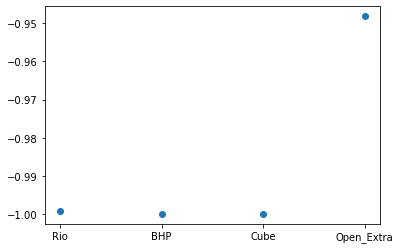

In [18]:
dfs=[portfolio_returns_rio,portfolio_returns_bhp,portfolio_returns_cube]
prices = functools.reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)
print(prices.columns)
prices=prices.rename(columns={"Open":"Open_Rio","Open_x":"Open_BHP","Open_y": "Open_Cube"})
#prices=rio_df.merge(bhp_df,cube_df, on="Date",suffixes=['_Rio','_BHP','_CUBE'])
#print(prices)
prices=pd.DataFrame({'Date':prices.index,'Rio':prices['Open_Rio'],'BHP':prices['Open_BHP'],'Cube':prices['Open_Cube']})
prices=pd.concat([prices,portfolio_returns_extra],axis=1)
prices=prices.rename(columns={"Open":"Open_Extra"})
print(prices.columns)

prices.set_index("Date",inplace=True)
#print(prices)

mean_returns=mean_historical_return(prices,frequency=252)

# Plot the annualized average historical return
plt.plot(mean_returns, linestyle = 'None', marker = 'o')
plt.show()

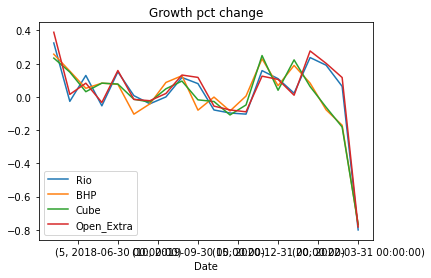

In [20]:
chg=prices.pct_change()
chg.plot()
plt.title('Growth pct change')
plt.show()



In [44]:
cs = CovarianceShrinkage(prices)
sample_cov = prices.pct_change().cov() * 252
e_cov = cs.ledoit_wolf()

print("Sample Covariance Matrix\n", sample_cov, "\n")
print("Efficient Covariance Matrix\n", e_cov, "\n")

Sample Covariance Matrix
                   Rio        BHP       Cube  Open_Extra
Rio         12.785174  10.189405  10.146697   12.810838
BHP         10.189405  11.743574  11.427682   10.084802
Cube        10.146697  11.427682  11.411637    9.978599
Open_Extra  12.810838  10.084802   9.978599   13.030341 

Efficient Covariance Matrix
                   Rio        BHP       Cube  Open_Extra
Rio         11.758625   2.405634   2.395551    3.024533
BHP          2.405634  11.512712   2.697981    2.380938
Cube         2.395551   2.697981  11.434345    2.355865
Open_Extra   3.024533   2.380938   2.355865   11.816507 



In [51]:
ef=pypfopt.efficient_frontier.EfficientFrontier(None, e_cov)
min_vol_weights=ef.min_volatility()
print("Percentage to be held in the portfolio in the period", min_vol_weights)

Percentage to be held in the portfolio in the period OrderedDict([('Rio', 0.2416104543338394), ('BHP', 0.2566004869760058), ('Cube', 0.2598754161322116), ('Open_Extra', 0.2419136425579434)])


Constrained Line Algorithm (CLA) class: generates the entire efficient frontier
1. requires covariance matrix of returns
2. requires proxy for expected future returns: mean historical returns
The expected return is the profit or loss that an investor anticipates on an investment that has known historical rates of return (RoR).


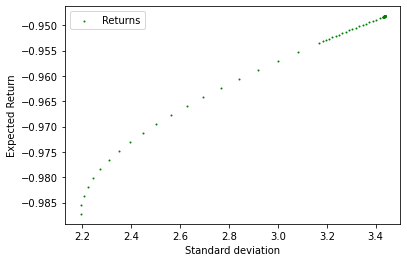

the expected returns is 10%


In [43]:
print("Constrained Line Algorithm (CLA) class: generates the entire efficient frontier")
print("1. requires covariance matrix of returns")
print("2. requires proxy for expected future returns: mean historical returns")
print("The expected return is the profit or loss that an investor anticipates on an investment that has known historical rates of return (RoR).")
    
cla=CLA(mean_returns,e_cov)

(ret, vol, weights) = cla.efficient_frontier()

# Add the frontier to the plot showing the 'before' and 'after' frontiers
plt.scatter(vol, ret, s = 4, c = 'g', marker = '.', label = 'Returns')
plt.xlabel('Standard deviation')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

print("the expected returns is 10%")

In [57]:
rio_returns=rio_df['open_pct_change']
bhp_returns=bhp_df['open_pct_change']
cube_returns=cube_df['open_pct_change']
extra_returns=extra_df['open_pct_change']

print("\nvolatility rio",np.sqrt(252)*rio_returns.std(),
      "\nvolatility bhp",np.sqrt(252)*bhp_returns.std(),
      "\nvolatility cube",np.sqrt(252)*cube_returns.std(),
      "\nvolatility extra",np.sqrt(252)*extra_returns.std())



volatility rio 0.320984359710016 
volatility bhp 0.3160800788382727 
volatility cube 0.2512766774855085 
volatility extra 0.2532336411858425


2017-02-01 00:00:00 45.110001 2
2017-02-13 00:00:00 46.080002 2
2017-03-02 00:00:00 42.490002 2
2017-03-08 00:00:00 41.029999 2
2017-03-13 00:00:00 40.790001 2
2017-03-16 00:00:00 43.400002 2
2017-03-29 00:00:00 40.560001 2
2017-04-04 00:00:00 41.049999 2
2017-04-11 00:00:00 41.860001 2
2017-04-24 00:00:00 40.080002 2
2017-04-28 00:00:00 40.110001 2
2017-05-10 00:00:00 39.02 2
2017-05-16 00:00:00 39.939999 2
2017-05-22 00:00:00 42.209999 2
2017-06-26 00:00:00 39.5 2
2017-06-29 00:00:00 42.169998 2
2017-07-12 00:00:00 44.73 2
2017-07-17 00:00:00 45.439999 2
2017-07-26 00:00:00 46.07 2
2017-08-04 00:00:00 47.07 2
2017-08-22 00:00:00 45.98 2
2017-08-31 00:00:00 48.84 2
2017-09-19 00:00:00 47.990002 2
2017-10-02 00:00:00 47.439999 2
2017-10-09 00:00:00 49.150002 2
2017-10-16 00:00:00 50.669998 2
2017-11-06 00:00:00 50.040001 2
2017-11-22 00:00:00 48.740002 2
2017-12-11 00:00:00 47.900002 2
2017-12-14 00:00:00 48.77 2
2017-12-21 00:00:00 50.970001 2
2017-12-28 00:00:00 52.630001 2
2018-01-0

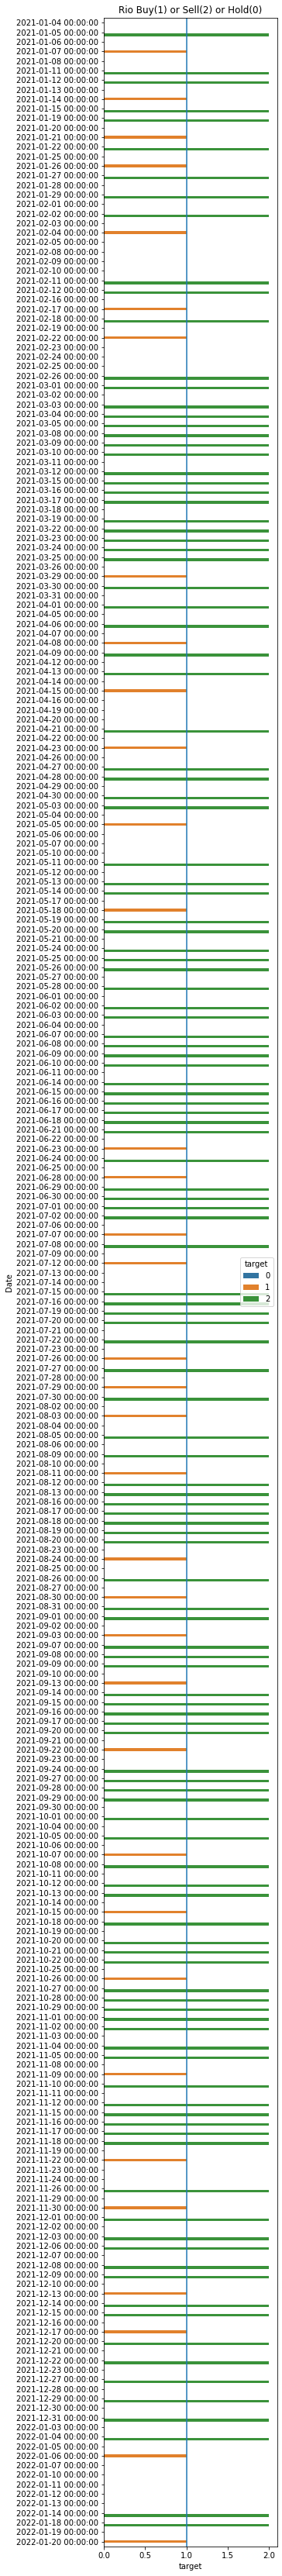

In [23]:
rio_df["buy_count"]=0

def SetOpenPositiveCount(df):
    df["open_pct_positive_count"]=0
    for index in range(len(df)):
    #print(df.iloc[index])
        count=0
        for index2 in (range(index,0,-1)):
            #print(df.iloc[index2]["open_pct_change"])
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
                #print("found",count)
            else:
                break
        #print("count",count)
        df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    return df

def SetPctChange(df):
    for index in range(len(df)):
        count=0
        for index2 in (range(index,0,-1)):
            if df.iloc[index2]["open_pct_change"]>0:
                count=count+1
            else:
                break
        df.iloc[index, df.columns.get_loc('buy_count')]=count
        
    df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
    df["target"]=0
    for index in range(len(df)):
        action=df.iloc[index]["action"]
        if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
        elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
    buy_list=df[df["target"]==1]
    for index,item in buy_list.iterrows():
        print(index,item["Open"],item["open_pct_positive_count"])
    
    today = datetime.datetime.today()
    filter=df.index.year >=  today.year-1
    results=df[filter]

    return results

rio_df=SetOpenPositiveCount(rio_df)
results=SetPctChange(rio_df)

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Rio Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 333
Sell 163
Hold 74


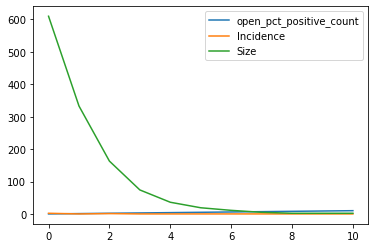

I  want low numbers of buy, high numbers of hold, and low numbers of sell.  Rio is very volatile.  This pattern could change in the near future


In [24]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(rio_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(rio_df[rio_df['open_pct_positive_count']==1]))
print("Sell",len(rio_df[rio_df['open_pct_positive_count']==2]))
print("Hold",len(rio_df[rio_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

print("I  want low numbers of buy, high numbers of hold, and low numbers of sell.  Rio is very volatile.  This pattern could change in the near future")

2017-02-01 00:00:00 41.5 2
2017-02-13 00:00:00 40.529999 2
2017-02-16 00:00:00 41.07 2
2017-03-02 00:00:00 38.650002 2
2017-03-13 00:00:00 36.389999 2
2017-03-16 00:00:00 38.290001 2
2017-03-29 00:00:00 36.43 2
2017-04-04 00:00:00 36.639999 2
2017-04-11 00:00:00 38.439999 2
2017-04-24 00:00:00 36.349998 2
2017-05-10 00:00:00 34.98 2
2017-05-16 00:00:00 35.990002 2
2017-05-22 00:00:00 36.889999 2
2017-06-12 00:00:00 35.380001 2
2017-06-19 00:00:00 34.84 2
2017-06-26 00:00:00 34.32 2
2017-07-05 00:00:00 37.02 2
2017-07-12 00:00:00 38.470001 2
2017-07-26 00:00:00 40.450001 2
2017-08-01 00:00:00 41.619999 2
2017-08-04 00:00:00 40.950001 2
2017-08-17 00:00:00 40.860001 2
2017-08-22 00:00:00 41.52 2
2017-08-25 00:00:00 42.59 2
2017-08-31 00:00:00 43.450001 2
2017-09-20 00:00:00 42.400002 2
2017-10-02 00:00:00 40.779999 2
2017-10-16 00:00:00 42.990002 2
2017-10-31 00:00:00 40.830002 2
2017-11-06 00:00:00 43.240002 2
2017-11-22 00:00:00 42.25 2
2017-12-01 00:00:00 41.669998 2
2017-12-11 00:00:

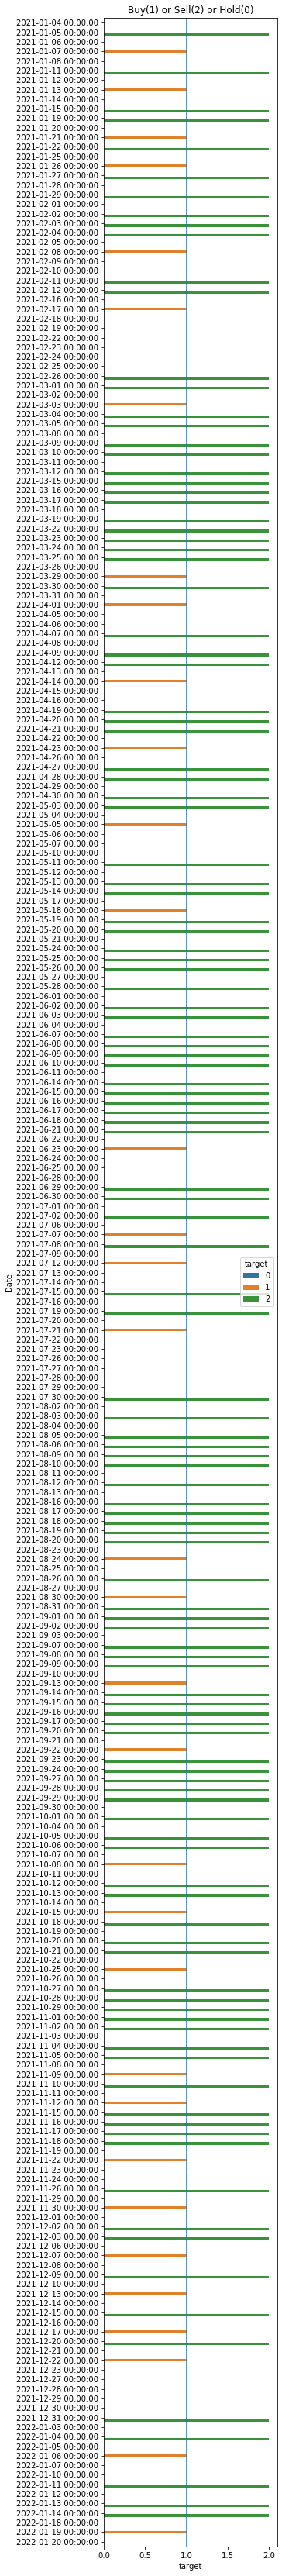

In [25]:
bhp_df["buy_count"]=0
bhp_df=SetOpenPositiveCount(bhp_df)
results=SetPctChange(bhp_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()    

Buy 322
Sell 160
Hold 84


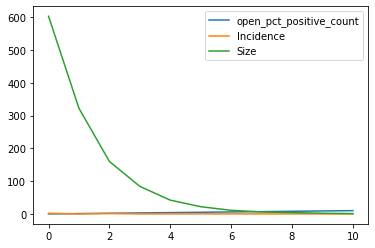

In [26]:
pig_table = create_pig_table(bhp_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(bhp_df[bhp_df['open_pct_positive_count']==1]))
print("Sell",len(bhp_df[bhp_df['open_pct_positive_count']==2]))
print("Hold",len(bhp_df[bhp_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

2017-02-02 00:00:00 25.16 2
2017-02-09 00:00:00 25.93 2
2017-02-17 00:00:00 25.950001 2
2017-02-27 00:00:00 27.379999 2
2017-03-08 00:00:00 27.25 2
2017-03-16 00:00:00 26.309999 2
2017-03-21 00:00:00 26.540001 2
2017-04-04 00:00:00 25.99 2
2017-04-18 00:00:00 27.809999 2
2017-05-08 00:00:00 24.940001 2
2017-05-24 00:00:00 25.290001 2
2017-06-14 00:00:00 24.09 2
2017-06-19 00:00:00 24.5 2
2017-07-03 00:00:00 24.139999 2
2017-07-13 00:00:00 23.389999 2
2017-07-24 00:00:00 24.18 2
2017-08-01 00:00:00 24.73 2
2017-08-08 00:00:00 24.549999 2
2017-08-15 00:00:00 24.42 2
2017-08-23 00:00:00 24.09 2
2017-09-06 00:00:00 24.92 2
2017-09-15 00:00:00 25.959999 2
2017-10-06 00:00:00 25.860001 2
2017-10-13 00:00:00 26.4 2
2017-10-20 00:00:00 26.379999 2
2017-10-30 00:00:00 26.99 2
2017-11-27 00:00:00 29.280001 2
2017-12-01 00:00:00 28.629999 2
2017-12-12 00:00:00 29.290001 2
2017-12-18 00:00:00 29.459999 2
2017-12-27 00:00:00 28.969999 2
2018-01-23 00:00:00 27.43 2
2018-02-01 00:00:00 27.5 2
2018-02

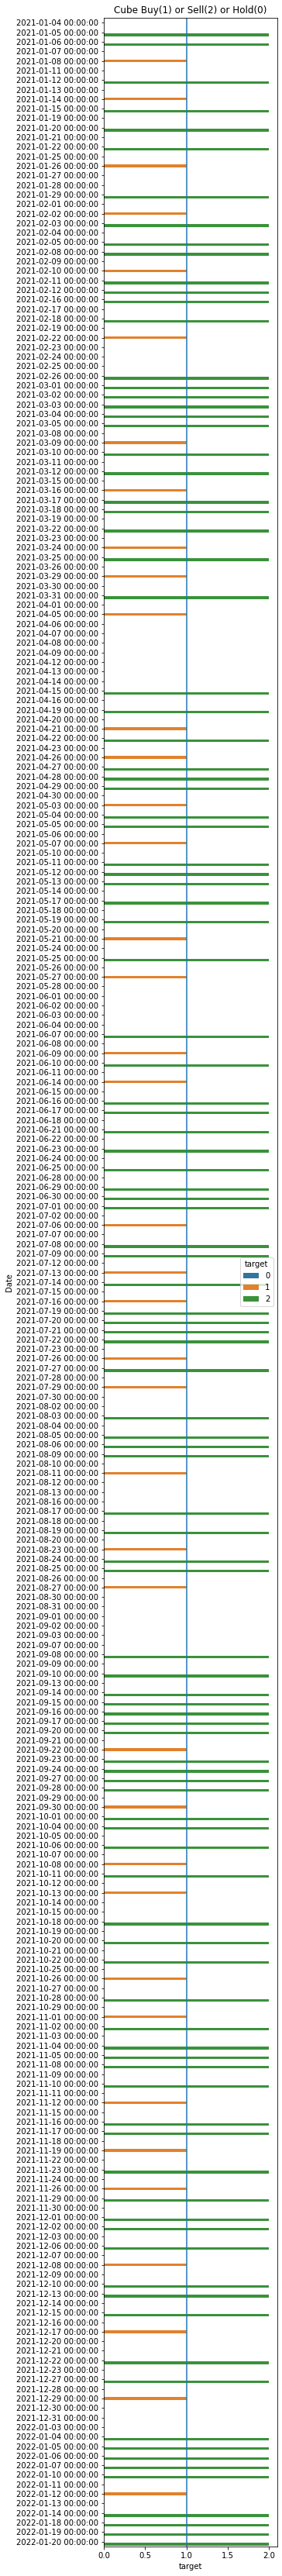

In [27]:
cube_df["buy_count"]=0
cube_df=SetOpenPositiveCount(cube_df)
results=SetPctChange(cube_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('Cube Buy(1) or Sell(2) or Hold(0)')
plt.show()  

Buy 313
Sell 168
Hold 93


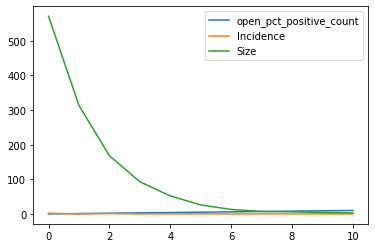

In [119]:
pig_table = create_pig_table(cube_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(cube_df[cube_df['open_pct_positive_count']==1]))
print("Sell",len(cube_df[cube_df['open_pct_positive_count']==2]))
print("Hold",len(cube_df[cube_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

2017-02-08 00:00:00 73.75 2
2017-02-17 00:00:00 75.010002 2
2017-02-27 00:00:00 79.660004 2
2017-03-16 00:00:00 75.510002 2
2017-03-21 00:00:00 75.57 2
2017-04-03 00:00:00 75.010002 2
2017-04-18 00:00:00 80.0 2
2017-05-08 00:00:00 73.629997 2
2017-05-19 00:00:00 76.059998 2
2017-06-14 00:00:00 75.870003 2
2017-06-19 00:00:00 78.290001 2
2017-07-03 00:00:00 78.629997 2
2017-07-14 00:00:00 76.120003 2
2017-08-01 00:00:00 79.699997 2
2017-08-15 00:00:00 76.760002 2
2017-08-23 00:00:00 75.769997 2
2017-08-30 00:00:00 77.690002 2
2017-09-06 00:00:00 78.5 2
2017-09-18 00:00:00 79.080002 2
2017-10-02 00:00:00 80.220001 2
2017-10-06 00:00:00 80.029999 2
2017-10-12 00:00:00 80.669998 2
2017-10-19 00:00:00 82.120003 2
2017-10-24 00:00:00 81.790001 2
2017-10-31 00:00:00 80.989998 2
2017-11-14 00:00:00 86.879997 2
2017-11-20 00:00:00 87.349998 2
2017-12-01 00:00:00 85.580002 2
2017-12-12 00:00:00 87.730003 2
2017-12-27 00:00:00 87.029999 2
2018-01-17 00:00:00 83.029999 2
2018-01-23 00:00:00 85.379

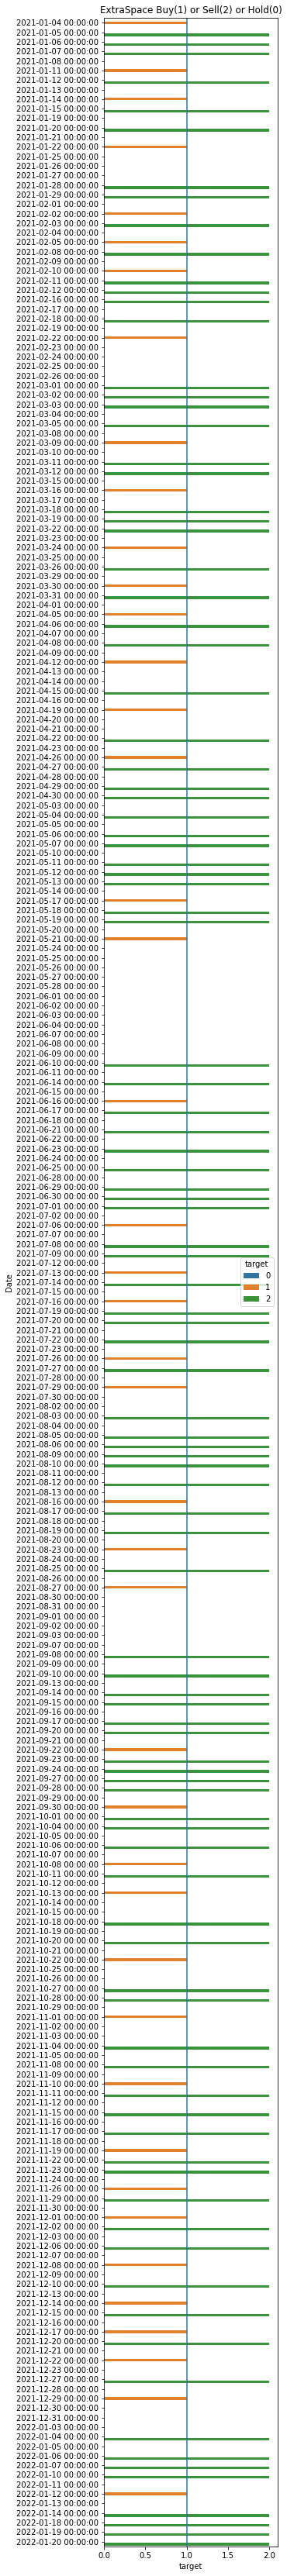

In [29]:
extra_df["buy_count"]=0
extra_df=SetOpenPositiveCount(extra_df)
results=SetPctChange(extra_df)
    

plt.figure(figsize=(4,60))
sns.barplot(data=results, x='target', y=results.index, hue='target')
plt.axvline(x=1, ymin=0, ymax=1)
plt.title('ExtraSpace Buy(1) or Sell(2) or Hold(0)')
plt.show() 

Buy 311
Sell 173
Hold 92


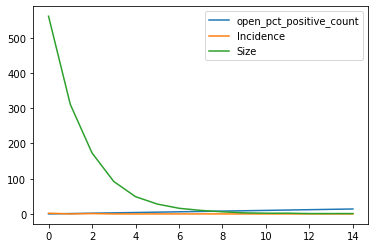

In [30]:
pig_table = create_pig_table(extra_df, "target", "open_pct_positive_count")
#print(pig_table)
print("Buy",len(cube_df[extra_df['open_pct_positive_count']==1]))
print("Sell",len(cube_df[extra_df['open_pct_positive_count']==2]))
print("Hold",len(cube_df[extra_df['open_pct_positive_count']==3]))

pig_table.plot()
plt.show()

Let see if the dividend earns are worth the risk


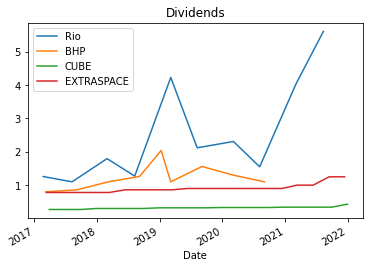

In [37]:
print("Let see if the dividend earns are worth the risk")
rio_dividend_df=pd.read_csv('RIO_Dividend.csv',parse_dates=['Date'],index_col=0)
bhp_dividend_df=pd.read_csv('BHP_Dividend.csv',parse_dates=['Date'],index_col=0)
cube_dividend_df=pd.read_csv('CUBE_Dividend.csv',parse_dates=['Date'],index_col=0)
extra_dividend_df=pd.read_csv('EXR_Dividend.csv',parse_dates=['Date'],index_col=0)

filter=rio_dividend_df.index>'1/1/2017'
rio_dividend_df=rio_dividend_df[filter]
rio_dividend_df['Dividends'].plot(label='Rio')
filter=bhp_dividend_df.index>'1/1/2017'
bhp_dividend_df=bhp_dividend_df[filter]
bhp_dividend_df['Dividends'].plot(label='BHP')
filter=cube_dividend_df.index>'1/1/2017'
cube_dividend_df=cube_dividend_df[filter]
cube_dividend_df['Dividends'].plot(label='CUBE')
extra_dividend_df=extra_dividend_df[filter]
extra_dividend_df['Dividends'].plot(label='EXTRASPACE')

plt.legend()
plt.title('Dividends')
plt.show()

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


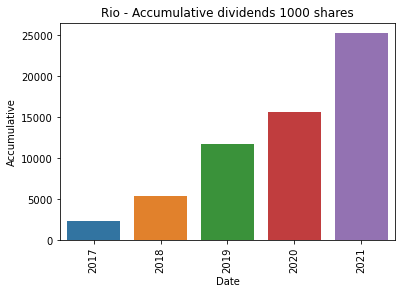

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


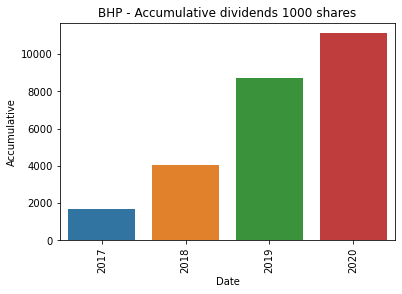

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


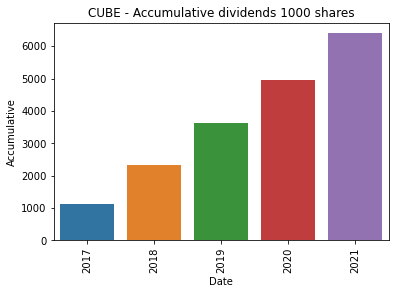

C:\Users\dnishimoto\Anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


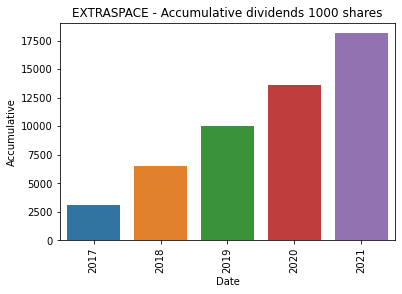

Rio 45070.0 Dividend Earning 25264.0   56.05502551586421
bhp 41180.0 Dividend Earning 11120.0 27.003399708596405
cube 25799.999 Dividend Earning 6400.0 24.806202511868314
extraspace 73839.996 Dividend Earning 18140.0 24.56663188334951


In [39]:
def AccumulativeEarnings(investment,df,title):
    df['Accum_Earnings']=df['Dividends'].apply(lambda x: x*investment)
    months=df.index.month
    years=df.index.year
    grouped=df.groupby([years,months])['Accum_Earnings'].sum()
    grouped=grouped.unstack()

    fp=df.pivot_table(index=df.index.year,columns=df.index.month,values=['Accum_Earnings'],aggfunc='sum')
    fp['Totals'] = fp.sum(axis='columns')
    fp['Accumulative']=fp['Totals'].cumsum()

    sns.barplot(fp.index,fp['Accumulative'])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()
    return fp

shares=1000

accum_rio_dividend=AccumulativeEarnings(shares,rio_dividend_df,"Rio - Accumulative dividends 1000 shares")
accum_bhp_dividend=AccumulativeEarnings(shares,bhp_dividend_df,"BHP - Accumulative dividends 1000 shares")
accum_cube_dividend=AccumulativeEarnings(shares,cube_dividend_df,"CUBE - Accumulative dividends 1000 shares")
accum_extra_dividend=AccumulativeEarnings(shares,extra_dividend_df,"EXTRASPACE - Accumulative dividends 1000 shares")

earning=float(accum_rio_dividend['Accumulative'].iloc[-1])
cost=rio_df['Open'].iloc[0]*shares
percent=float(earning)/float(cost)*100
print("Rio {cost} Dividend Earning {earning}   {percent}".format(cost=cost,earning=earning,percent=percent))

earning=accum_bhp_dividend['Accumulative'].iloc[-1]
cost=bhp_df['Open'].iloc[0]*shares
percent=earning/cost*100
print("bhp {cost} Dividend Earning {earning} {percent}".format(cost=cost,earning=earning,percent=percent))

earning=accum_cube_dividend['Accumulative'].iloc[-1]
cost=cube_df['Open'].iloc[0]*shares
percent=earning/cost*100
print("cube {cost} Dividend Earning {earning} {percent}".format(cost=cost,earning=earning,percent=percent))

earning=accum_extra_dividend['Accumulative'].iloc[-1]
cost=extra_df['Open'].iloc[0]*shares
percent=earning/cost*100
print("extraspace {cost} Dividend Earning {earning} {percent}".format(cost=cost,earning=earning,percent=percent))



Predicted Dividend pct change


<AxesSubplot:xlabel='Date'>

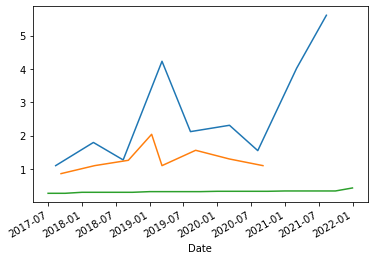

In [36]:
print("Predicted Dividend pct change")

def dividend_by_pct_chg(df):

    first_dividend=df['Dividends'].iloc[0]
    returns=df['Dividends'].pct_change()
    returns_plus_one = returns.add(1)
    accumulative=returns_plus_one.cumprod()
    accumulative=accumulative.mul(first_dividend)
    return accumulative

def plotARMA(df_accumulative,ax,label):
    result=df_accumulative
    result=result.rolling(window=45).mean().dropna()
    mod = sm.tsa.arima.ARIMA(result, order=(2,0,0))
    res = mod.fit()
    # Plot the original series and the forecasted series
    #res.plot_predict(start=0, end=400)
    df_accumulative.plot(ax=ax,label=label)
    res.predict().plot(ax=ax,label=label)

accum_rio_dividend_growth=dividend_by_pct_chg(rio_dividend_df)    
accum_bhp_dividend_growth=dividend_by_pct_chg(bhp_dividend_df)    
accum_cube_dividend_growth=dividend_by_pct_chg(cube_dividend_df)    

accum_rio_dividend_growth.plot()
accum_bhp_dividend_growth.plot()
accum_cube_dividend_growth.plot()

#fig,ax = plt.subplots(figsize=(20,20))    
#plotARMA(accum_rio_dividend_growth,ax,"Rio")
#plotARMA(accum_bhp_dividend_growth,ax,"BHP")
#plt.legend(fontsize=8)
#plt.title("ARMA")
#plt.show()

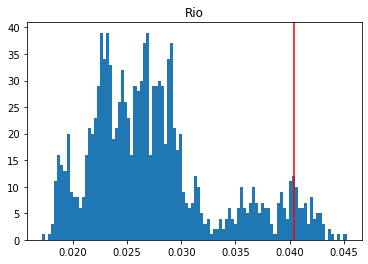

VaR 95 0.0404475868438168 VaR 99 0.04265047644284621


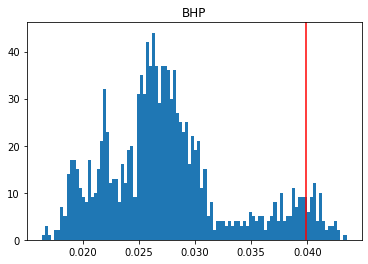

VaR 95 0.039842932472071935 VaR 99 0.041851609641155973


In [58]:
#VaR_95 = norm.ppf(0.95)
#VaR_95 = np.quantile(prices, 0.95)
#print(VaR_95)

array=prices['Rio']
data=preprocessing.normalize([array]).flatten()
#print(data)
VaR_99 = np.quantile(data, 0.99)
VaR_95 = np.quantile(data, 0.95)

plt.hist(data, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
#plt.hist(prices['BHP'], bins = 100)
plt.title('Rio')
plt.show()

print("VaR 95",VaR_95,"VaR 99",VaR_99)

array=prices['BHP']
data=preprocessing.normalize([array]).flatten()
#print(data)
VaR_99 = np.quantile(data, 0.99)
VaR_95 = np.quantile(data, 0.95)

plt.hist(data, bins = 100)
plt.axvline(x = VaR_95, c='r', label = "VaR at 95% Confidence Level")
#plt.hist(prices['BHP'], bins = 100)
plt.title('BHP')
plt.show()

print("VaR 95",VaR_95,"VaR 99",VaR_99)